### Install 

In [1]:
# === Cell 1 — Install dependencies for cleaning + Marian training (from scratch) ===
# - transformers/sentencepiece/accelerate: model + tokenizer + mixed precision
# - datasets: dataset wrappers + Trainer input
# - sacrebleu: BLEU/chrF evaluation
# - nltk/jieba: tokenization, stemming/lemmatization (assignment requirement)
# - scikit-learn: TF-IDF (assignment feature extraction requirement)
# - matplotlib: simple plots for training curves
!pip install -q transformers sentencepiece accelerate datasets sacrebleu nltk jieba scikit-learn matplotlib

# minimal NLTK resources for tokenization/lemmatization demos
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)


True

In [2]:
# === Cell 2 — Imports & global configuration (from-scratch Marian training) ===
from pathlib import Path
import os, re, json, unicodedata, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from datasets import Dataset, DatasetDict
import sacrebleu  # for BLEU/chrF later

# ---- Paths ----
DATA_PATH = Path("/AI2/dataset_CN_EN.txt")   # your CN<TAB>EN file
RUN_DIR   = Path("marian_zh_en_scratch_run")
RUN_DIR.mkdir(parents=True, exist_ok=True)

# ---- Reproducibility ----
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---- Device ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---- Training hyperparameters (scratch needs more steps; adjust if needed) ----
EPOCHS         = 12          # increase if dataset is small
LR             = 3e-4        # higher than fine-tune learning rate
BSZ            = 16          # lower if OOM; you can use 8/4
GRAD_ACCUM     = 1           # raise if you reduce BSZ
WARMUP_RATIO   = 0.08
WEIGHT_DECAY   = 1e-2
LABEL_SMOOTH   = 0.1
MAX_SRC        = 128         # truncation lengths (raise if VRAM allows)
MAX_TGT        = 128
LOG_STEPS      = 50

# Persist a small run-config for reference
cfg = {
    "seed": SEED, "device": DEVICE, "epochs": EPOCHS, "lr": LR, "batch_size": BSZ,
    "grad_accum": GRAD_ACCUM, "warmup_ratio": WARMUP_RATIO, "weight_decay": WEIGHT_DECAY,
    "label_smooth": LABEL_SMOOTH, "max_src": MAX_SRC, "max_tgt": MAX_TGT,
    "data_path": str(DATA_PATH), "run_dir": str(RUN_DIR),
}
(RUN_DIR / "config.json").write_text(json.dumps(cfg, indent=2), encoding="utf-8")
print("Config saved to:", RUN_DIR / "config.json")


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Config saved to: marian_zh_en_scratch_run\config.json


In [3]:
# === Cell 3 — Load raw dataset & BEFORE preview ===
from IPython.display import display

assert DATA_PATH.exists(), f"Missing dataset: {DATA_PATH}"
df_raw = pd.read_csv(DATA_PATH, sep="\t", header=None, names=["cn","en"], dtype=str)

print("RAW shape:", df_raw.shape)
display(df_raw.head(10))  # BEFORE cleaning preview


RAW shape: (20289, 2)


,cn,en
0,嗨。,Hi.
1,你好。,Hi.
2,跑。,Run.
3,等等！,Wait!
4,你好。,Hello!
5,让我来。,I try.
6,我赢了。,I won!
7,不会吧。,Oh no!
8,乾杯!,Cheers!
9,他跑了。,He ran.


In [4]:
# === Cell 4 — Clean text + BEFORE/AFTER view (assignment: text cleaning) ===
import re, unicodedata
from IPython.display import display

# zero-width chars set
ZWSP = "".join(["\u200b","\u200c","\u200d","\ufeff"])

def normalize(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = unicodedata.normalize("NFKC", s)     # Unicode normalize
    s = re.sub(f"[{ZWSP}]", "", s)           # remove zero-width chars
    s = re.sub(r"\s+", " ", s).strip()       # collapse whitespace
    return s

df = df_raw.copy()
df["cn_clean"] = df["cn"].map(normalize)
df["en_clean"] = df["en"].map(normalize)

before_after = pd.DataFrame({
    "cn_before": df_raw["cn"], "cn_after": df["cn_clean"],
    "en_before": df_raw["en"], "en_after": df["en_clean"]
})
changed = int(((before_after.cn_before != before_after.cn_after) |
               (before_after.en_before != before_after.en_after)).sum())
print("Rows changed by cleaning:", changed)

display(before_after.head(10))


Rows changed by cleaning: 3694


,cn_before,cn_after,en_before,en_after
0,嗨。,嗨。,Hi.,Hi.
1,你好。,你好。,Hi.,Hi.
2,跑。,跑。,Run.,Run.
3,等等！,等等!,Wait!,Wait!
4,你好。,你好。,Hello!,Hello!
5,让我来。,让我来。,I try.,I try.
6,我赢了。,我赢了。,I won!,I won!
7,不会吧。,不会吧。,Oh no!,Oh no!
8,乾杯!,乾杯!,Cheers!,Cheers!
9,他跑了。,他跑了。,He ran.,He ran.


In [5]:
# === Cell 5 — Drop empties/duplicates + deterministic 80/10/10 split ===
import numpy as np
from IPython.display import display

n0 = len(df)
df2 = df.replace({"": np.nan}).dropna(subset=["cn_clean","en_clean"])
dup_count = int(df2.duplicated(subset=["cn_clean","en_clean"]).sum())
df2 = df2.drop_duplicates(subset=["cn_clean","en_clean"]).reset_index(drop=True)
print(f"After clean: {len(df2)} rows (removed {n0-len(df2)} empties + {dup_count} duplicates)")

# Deterministic shuffle & split
rng = np.random.default_rng(SEED)
idx = np.arange(len(df2)); rng.shuffle(idx)
n = len(idx)
i_train = idx[: int(0.8*n)]
i_valid = idx[int(0.8*n): int(0.9*n)]
i_test  = idx[int(0.9*n):]

train_df = df2.iloc[i_train][["cn_clean","en_clean"]].rename(columns={"cn_clean":"cn","en_clean":"en"}).reset_index(drop=True)
valid_df = df2.iloc[i_valid][["cn_clean","en_clean"]].rename(columns={"cn_clean":"cn","en_clean":"en"}).reset_index(drop=True)
test_df  = df2.iloc[i_test ][["cn_clean","en_clean"]].rename(columns={"cn_clean":"cn","en_clean":"en"}).reset_index(drop=True)

print(f"train={len(train_df)}  valid={len(valid_df)}  test={len(test_df)}")
display(train_df.head(5)); display(valid_df.head(5))


After clean: 20285 rows (removed 4 empties + 4 duplicates)
train=16228  valid=2028  test=2029


,cn,en
0,麻煩您稍待一下。,Will you wait a moment?
1,你怎麼什麼話也沒說?,How come you didn't say anything?
2,我會告訴我的妻子。,I'll tell my wife.
3,你認為它是陷阱嗎?,Do you think it's a trap?
4,"我们那时在谈论事情,但我不记得是什么了。","We were talking about something at that time, ..."


,cn,en
0,她總是穿著黑色的衣服。,She always wears black.
1,湯姆很可能遲到。,Tom is quite likely to be late.
2,汤姆找不到玛丽。,Tom can't find Mary.
3,"我的手抖得太厉害,没法穿针了。",My hands were shaking too much to thread the n...
4,我担心他的健康。,I was worried about his health.


In [6]:
# === Cell 6 (fixed) — Build HF Datasets & tokenize for Marian (prep for training) ===
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict

MODEL_NAME = "Helsinki-NLP/opus-mt-zh-en"   # tokenizer only; model will be from-scratch next
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Preprocess: CN → input_ids, EN → labels (both truncated to MAX_SRC/MAX_TGT)
def preprocess(batch):
    model_inputs = tokenizer(batch["cn"], max_length=MAX_SRC, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["en"], max_length=MAX_TGT, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Wrap pandas splits into HF DatasetDict
hf_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(valid_df),
    "test": Dataset.from_pandas(test_df),
})

# Remove only columns that actually exist (some pandas versions don't add __index_level_0__)
cols_in = hf_ds["train"].column_names
to_remove = [c for c in ["cn", "en", "__index_level_0__", "index"] if c in cols_in]

tok_ds = hf_ds.map(preprocess, batched=True, remove_columns=to_remove)
print(tok_ds)
print("Columns removed:", to_remove)
print("Example tokenized keys:", tok_ds["train"][0].keys())


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Map:   0%|          | 0/16228 [00:00<?, ? examples/s]C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 2029/2029 [00:00<00:00, 8405.78 examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 16228
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2028
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2029
    })
})
Columns removed: ['cn', 'en']
Example tokenized keys: dict_keys(['input_ids', 'attention_mask', 'labels'])


In [7]:
# === Cell 7 — Create Marian Transformer *from scratch* + collator ===
from transformers import AutoConfig, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
import math

MODEL_NAME = "Helsinki-NLP/opus-mt-zh-en"  # use Marian architecture config only

# Load architecture hyperparameters (no weights), then build random-initialized model
config = AutoConfig.from_pretrained(MODEL_NAME)
model  = AutoModelForSeq2SeqLM.from_config(config)

# Make sure embedding sizes match the tokenizer (safe even if already equal)
model.resize_token_embeddings(len(tokenizer))

# Move to GPU/CPU
model.to(DEVICE)

# Collator handles dynamic padding for batches
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# Quick model info
num_params = sum(p.numel() for p in model.parameters())
print(f"Marian (from scratch) initialized. Parameters: {num_params/1e6:.1f}M | Vocab size: {len(tokenizer)} | Device: {DEVICE}")

Marian (from scratch) initialized. Parameters: 77.9M | Vocab size: 65001 | Device: cuda


In [15]:
# === Cell 8 — Metrics: BLEU only ===
import numpy as np
import sacrebleu

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    pred_texts = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    ref_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bleu = sacrebleu.corpus_bleu(pred_texts, [ref_texts]).score
    return {"bleu": bleu}


In [19]:
# === Cell 9 — Safe-resume Trainer (scratch-aware) + train & save ===
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from pathlib import Path
import math, inspect
from transformers import AutoConfig

ckpt_dir = RUN_DIR / "checkpoints"
ckpt_dir.mkdir(parents=True, exist_ok=True)

# ---- step estimates for fallbacks ----
train_len = len(tok_ds["train"])
steps_per_epoch = max(1, math.ceil(train_len / max(1, BSZ)) // max(1, GRAD_ACCUM))
total_steps = steps_per_epoch * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

# ---- detect supported args on your transformers version ----
sig = set(inspect.signature(Seq2SeqTrainingArguments.__init__).parameters.keys())
has_eval_strategy = ("evaluation_strategy" in sig) or ("eval_strategy" in sig)
has_save_strategy = ("save_strategy" in sig)
has_load_best     = ("load_best_model_at_end" in sig and
                     "metric_for_best_model" in sig and
                     "greater_is_better" in sig)

kw = dict(
    output_dir=str(ckpt_dir),
    overwrite_output_dir=False,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BSZ,
    per_device_eval_batch_size=BSZ,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    fp16=(DEVICE == "cuda"),
    logging_steps=LOG_STEPS,
    seed=SEED,
)

# warmup
if "warmup_ratio" in sig: kw["warmup_ratio"] = WARMUP_RATIO
elif "warmup_steps" in sig: kw["warmup_steps"] = warmup_steps

# label smoothing
if "label_smoothing_factor" in sig: kw["label_smoothing_factor"] = LABEL_SMOOTH

# prefer epoch strategies when available; else step fallbacks
if has_eval_strategy:
    if "evaluation_strategy" in sig: kw["evaluation_strategy"] = "epoch"
    else: kw["eval_strategy"] = "epoch"
if has_save_strategy: kw["save_strategy"] = "epoch"
if "save_total_limit" in sig: kw["save_total_limit"] = 3
if "predict_with_generate" in sig: kw["predict_with_generate"] = True
if "report_to" in sig: kw["report_to"] = "none"
if not has_eval_strategy and "eval_steps" in sig: kw["eval_steps"] = steps_per_epoch
if not has_save_strategy and "save_steps" in sig: kw["save_steps"] = steps_per_epoch

# only enable load_best if both strategies exist (prevents mismatch error)
if has_load_best and has_eval_strategy and has_save_strategy:
    kw["load_best_model_at_end"] = True
    kw["metric_for_best_model"] = "bleu"
    kw["greater_is_better"] = True

args = Seq2SeqTrainingArguments(**kw)

# ---- Safe checkpoint compatibility check ----
def is_compatible_checkpoint(p: Path) -> bool:
    try:
        ck_cfg = AutoConfig.from_pretrained(p)
    except Exception:
        return False
    same_type   = getattr(ck_cfg, "model_type", None) == getattr(model.config, "model_type", None)
    same_layers = (getattr(ck_cfg, "encoder_layers", None) == getattr(model.config, "encoder_layers", None) and
                   getattr(ck_cfg, "decoder_layers", None) == getattr(model.config, "decoder_layers", None))
    same_hidden = getattr(ck_cfg, "d_model", None) == getattr(model.config, "d_model", None)
    # vocab must match current tokenizer length
    try:
        ck_vocab = ck_cfg.vocab_size
    except Exception:
        ck_vocab = None
    same_vocab = (ck_vocab == len(tokenizer))
    return bool(same_type and same_layers and same_hidden and same_vocab)

# ---- Pick latest compatible checkpoint (if any); else start fresh ----
resume = None
if ckpt_dir.exists():
    all_ckpts = sorted(ckpt_dir.glob("checkpoint-*"), key=lambda p: int(p.name.split("-")[-1]))
    for p in reversed(all_ckpts):
        if is_compatible_checkpoint(p):
            resume = str(p); break

print("Resume checkpoint:", resume if resume else "None (fresh run)")

# ---- Trainer ----
try:
    from transformers import EarlyStoppingCallback
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
except Exception:
    callbacks = []

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # BLEU only (your Cell 8)
    callbacks=callbacks,
)

# ---- Train ----
trainer.train(resume_from_checkpoint=resume)

# ---- Save model/tokenizer ----
best_dir = RUN_DIR / "best_model"
trainer.save_model(best_dir)
tokenizer.save_pretrained(best_dir)

best_ckpt  = getattr(trainer.state, "best_model_checkpoint", None)
best_metric= getattr(trainer.state, "best_metric", None)
print("Best checkpoint:", best_ckpt)
print("Best BLEU:", best_metric)


Resume checkpoint: marian_zh_en_scratch_run\checkpoints\checkpoint-12180


C:\Users\USER\AppData\Local\Temp\ipykernel_19164\3241664278.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


Epoch,Training Loss,Validation Loss


Best checkpoint: marian_zh_en_scratch_run\checkpoints\checkpoint-12180
Best BLEU: 29.626826241197346


In [18]:
# === Cell 10 — Evaluate on VALID & TEST + sample translations (BLEU/chrF) ===
from transformers import AutoModelForSeq2SeqLM
import json

# 1) Load best saved model if present, else use the current model in memory
best_dir = RUN_DIR / "best_model"
eval_model = None
try:
    if best_dir.exists():
        eval_model = AutoModelForSeq2SeqLM.from_pretrained(best_dir).to(DEVICE)
        print("Loaded best model from:", best_dir)
except Exception as e:
    print("Could not load best model from disk, using in-memory model. Reason:", e)

if eval_model is None:
    eval_model = model  # fallback to the model you just trained

# 2) Translate helper (batched) with beam search
@torch.no_grad()
def translate_marian(texts, beams=4, max_new_tokens=128, bs=64):
    outs = []
    eval_model.eval()
    for i in range(0, len(texts), bs):
        batch = texts[i:i+bs]
        enc = tokenizer(batch, return_tensors="pt", padding=True,
                        truncation=True, max_length=MAX_SRC).to(DEVICE)
        gen = eval_model.generate(
            **enc,
            num_beams=beams,
            max_new_tokens=max_new_tokens,
            no_repeat_ngram_size=3,
            length_penalty=1.0,
        )
        outs += tokenizer.batch_decode(gen, skip_special_tokens=True)
    return outs

# 3) Evaluate on VALID
valid_pred = translate_marian(valid_df["cn"].tolist(), beams=4, max_new_tokens=128, bs=48)
valid_bleu = sacrebleu.corpus_bleu(valid_pred, [valid_df["en"].tolist()]).score
valid_chrf = sacrebleu.corpus_chrf(valid_pred, [valid_df["en"].tolist()]).score

# 4) Evaluate on TEST
test_pred  = translate_marian(test_df["cn"].tolist(),  beams=4, max_new_tokens=128, bs=48)
test_bleu  = sacrebleu.corpus_bleu(test_pred,  [test_df["en"].tolist()]).score
test_chrf  = sacrebleu.corpus_chrf(test_pred,  [test_df["en"].tolist()]).score

print(f"VALID  | BLEU {valid_bleu:.2f}  chrF {valid_chrf:.2f}")
print(f"TEST   | BLEU {test_bleu:.2f}  chrF {test_chrf:.2f}")

# 5) Show a small sample table for the report
display(pd.DataFrame({
    "CN": valid_df["cn"].head(10).tolist(),
    "REF_EN": valid_df["en"].head(10).tolist(),
    "PRED_EN": valid_pred[:10]
}))

# 6) Save metrics and sample predictions
metrics = {
    "valid_bleu": float(valid_bleu),
    "valid_chrf": float(valid_chrf),
    "test_bleu": float(test_bleu),
    "test_chrf": float(test_chrf),
}
(RUN_DIR / "eval").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "eval" / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")
pd.DataFrame({
    "cn": valid_df["cn"],
    "ref_en": valid_df["en"],
    "pred_en": valid_pred
}).to_csv(RUN_DIR / "eval" / "valid_preds.csv", index=False)
pd.DataFrame({
    "cn": test_df["cn"],
    "ref_en": test_df["en"],
    "pred_en": test_pred
}).to_csv(RUN_DIR / "eval" / "test_preds.csv", index=False)
print("Saved metrics & preds to:", RUN_DIR / "eval")


Loaded best model from: marian_zh_en_scratch_run\best_model
VALID  | BLEU 29.45  chrF 45.74
TEST   | BLEU 28.00  chrF 44.36


,CN,REF_EN,PRED_EN
0,她總是穿著黑色的衣服。,She always wears black.,She is always dressed in black.
1,湯姆很可能遲到。,Tom is quite likely to be late.,Tom will never be late.
2,汤姆找不到玛丽。,Tom can't find Mary.,Tom couldn't find Mary.
3,"我的手抖得太厉害,没法穿针了。",My hands were shaking too much to thread the n...,"My joints a high discount, but I can't be seen."
4,我担心他的健康。,I was worried about his health.,I'm concerned about his health.
5,汤姆假装没听见。,Tom pretended to not hear a thing.,Tom pretended not to hear.
6,他昨天來我的辦公室。,He came to my office yesterday.,He came to my office yesterday.
7,你為什麼哭?,What are you crying for?,Why did you cry?
8,我媽媽的廚藝很好。,My mother is a very good cook.,My mother's cooking.
9,從這裡到公園距離兩英里。,It is two miles from here to the park.,It is four miles from here to the park.


Saved metrics & preds to: marian_zh_en_scratch_run\eval


,epoch,eval_bleu,eval_chrf,eval_loss,learning_rate
0,1.0,0.472992,10.873143,4.686966,NaN
1,2.0,3.476052,18.309280,4.200771,NaN
2,3.0,8.983332,23.264495,3.920680,NaN
3,4.0,14.592722,30.358078,3.702260,NaN
4,5.0,18.897853,34.883188,3.545983,NaN
5,6.0,21.005765,38.265480,3.465151,NaN
6,7.0,24.232224,40.642344,3.412286,NaN
7,8.0,26.325633,42.634505,3.403461,NaN
8,9.0,27.246624,43.786172,3.407326,NaN
9,10.0,28.073061,44.508182,3.402221,NaN


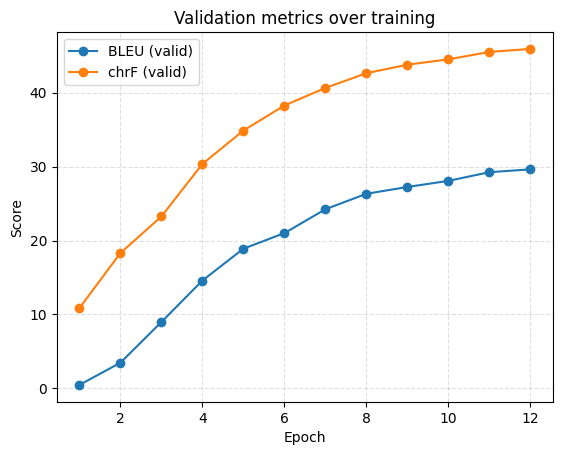

Saved plot to: marian_zh_en_scratch_run\eval\training_curves.png
Saved metrics CSV to: marian_zh_en_scratch_run\eval\training_metrics.csv


In [14]:
# === Cell 11 — Plot training curves (BLEU/chrF over epochs) & save artifacts ===
import pandas as pd
import matplotlib.pyplot as plt

logs = getattr(trainer.state, "log_history", None)
if not logs:
    print("No log history found on this Trainer instance.")
else:
    df_logs = pd.DataFrame(logs)

    # Keep only evaluation rows if available
    cols = ["epoch", "eval_bleu", "eval_chrf", "eval_loss", "learning_rate"]
    present = [c for c in cols if c in df_logs.columns]
    if "eval_bleu" in df_logs.columns:
        eval_df = df_logs[df_logs["eval_bleu"].notna()][present].reset_index(drop=True)
    else:
        # Fallback: keep any rows that have "eval_loss" as proxy
        mask = df_logs["eval_loss"].notna() if "eval_loss" in df_logs.columns else pd.Series([False]*len(df_logs))
        eval_df = df_logs[mask][present].reset_index(drop=True)

    if len(eval_df) == 0:
        print("No evaluation metrics recorded (older transformers?).")
        display(df_logs.tail(15))
    else:
        display(eval_df.tail(len(eval_df)))  # show all eval epochs compactly

        # Plot BLEU/chrF if present
        plt.figure()
        if "eval_bleu" in eval_df.columns:
            plt.plot(eval_df["epoch"], eval_df["eval_bleu"], marker="o", label="BLEU (valid)")
        if "eval_chrf" in eval_df.columns:
            plt.plot(eval_df["epoch"], eval_df["eval_chrf"], marker="o", label="chrF (valid)")
        plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation metrics over training")
        if ("eval_bleu" in eval_df.columns) or ("eval_chrf" in eval_df.columns):
            plt.legend()
        plt.grid(True, linestyle="--", alpha=0.4)
        (RUN_DIR / "eval").mkdir(parents=True, exist_ok=True)
        fig_path = RUN_DIR / "eval" / "training_curves.png"
        plt.savefig(fig_path, bbox_inches="tight")
        plt.show()
        print("Saved plot to:", fig_path)

        # Save metrics table
        csv_path = RUN_DIR / "eval" / "training_metrics.csv"
        eval_df.to_csv(csv_path, index=False)
        print("Saved metrics CSV to:", csv_path)
